In [1]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from yellowbrick.text import TSNEVisualizer,UMAPVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [ ]:
# nltk.download('stopwords')
# nltk.download('wordnet')

## Pre-Processing text data

In [3]:
def preprocess(raw_text):
    
    # tokenize words
    tokenized_words = word_tokenize(raw_text)

    # keep only words - remove punctuation
    letters_only_text = [re.sub("[^a-zA-Z]", " ", text) for text in tokenized_words]

    # convert to lower case 
    words = [word.lower() for word in letters_only_text]

    # remove stopwords + useless words
    stopword_set = set(stopwords.words("english") + ['immigration'] + ['immigrants'])
    cleaned_words = list(set([w for w in words if w not in stopword_set]))
    
    # remove blank spaces from list
    cleaned_words = [re.sub(" ", "", text) for text in cleaned_words]
    cleaned_words = list(filter(None, cleaned_words))
    
    # Stem/lemmitize words
    #porter=PorterStemmer()
    #stemmed_words = [porter.stem(word) for word in cleaned_words]
    lemmatizer = WordNetLemmatizer()
    lemmitized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
    
    # put list of words back into a corpus doc
    cleaned_corpus = ' '.join(word for word in lemmitized_words)

    return cleaned_corpus

In [4]:
# Load data
article_df = pd.read_csv('data/immigration_2000.csv')
article_df['index'] = list(range(0,2000))

text_df = pd.read_csv('data/article_text/df_text_1892.csv', index_col=[0])

#article_df.tail()

In [5]:
# Merge data
text_df = text_df.merge(article_df, left_index=True, right_index=True, how='left')
text_df = text_df.reset_index()

In [6]:
text_df['all_text'] = [preprocess(row) for row in text_df['all_text']]

In [7]:
text_df['all_text'][0]

'including behavior next immigration region billion could entry preferred discounted educational friday everdeveloping reported society famously first every reportedly impulse statement hardliner excised implicated environment reconstitute make income revised united bottom obvious continent tanzania amount free hierarchy democratic much bit member mulatto saw deal african established national attempt risk ngai law intends element evidence struggled operation nativist black elevation southeast granted group negro ineligible illegality act president racialization offlimits basis benefit percountry kidnapping banned mass foreignness elevated several subtracted economy worked ignorant farreaching population cato continues vision attainment setting heart seven citing public pending articulate terrorist legal new government europe american nigerian early said aid american court people european stratify security limit written th barred number matter libertarian america actually shithole type 

In [8]:
print("number of articles in corpus:", text_df.shape[0])

number of articles in corpus: 1892


## Additional data cleaning to be ignored for now

In [ ]:
# Create column for editorial board or not
text_df['editorial_board'] = [1 if row=='The Editorial Board' else 0 for row in text_df['byline']]
#[x+1 if x >= 45 else x+5 for x in l]

In [ ]:
# Working with just the abstract, title, and lead paragraph
article_df['text'] = article_df.abstract + " " + article_df.lead_paragraph + " " + article_df.headline
# Search for all non-letters, Replace all non-letters with spaces

article_df['text'] = [re.sub("[^a-zA-Z]",  " ", str(row)) for row in article_df['text']]
article_df['text'] = [preprocess(row) for row in article_df['text']]
article_df['text']

## Some EDA

In [ ]:
# data cleaning & simplifying
#text_df['byline'] = text_df['byline'].replace({'By ':''}, regex=True)

# remove no data
#text_df = text_df.dropna(subset=['byline'])

# Sometime there are multiple authors for an article - replace the first author for each article
#text_df['byline'] = [row.split('and')[0] for row in text_df['byline']]

print("number of articles in corpus:", text_df.shape[0])

In [ ]:
## Which authors publish the most articles in our dataset?
# authors_gby = text_df.groupby(['byline']).size()
# authors_gby = authors_gby.sort_values(ascending=False)
# authors_gby.head(20)
#authors_gby.to_csv('data/author_article_count.csv')

In [ ]:
## What is the span of dates for our dataset? 
article_df['pub_date'] = pd.to_datetime(article_df['pub_date'])
article_years = article_df.reset_index().set_index('pub_date').resample('Y').size()
article_years

In [ ]:
text_df['pub_date'] = pd.to_datetime(text_df['pub_date'])
text_df = text_df[text_df['pub_date'] > '2005-12-31 00:00:00+00:00']
text_df.shape

Articles go back really far. I might try to get more articles and cut it off to just the past 5 or 10 years.

## Topic Modeling

#### TFIDF with LSA

In [142]:
#vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english')
vectorizer=TfidfVectorizer(use_idf=True, stop_words='english')
doc_word = vectorizer.fit_transform(text_df['all_text'])
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)
topic_word = pd.DataFrame(lsa.components_.round(3),
             columns = vectorizer.get_feature_names())

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
display_topics(lsa, vectorizer.get_feature_names(), 30)


Topic  0
year, state, american, country, law, republican, policy, right, time, make, family, border, president, people, million, mr, way, like, child, government, need, new, day, want, say, work, united, said, issue, come

Topic  1
court, deportation, law, enforcement, federal, criminal, judge, department, homeland, administration, officer, agency, custom, abuse, lawyer, agent, police, official, justice, crime, detention, local, security, case, arrest, legal, profiling, arizona, supreme, jail

Topic  2
refugee, migrant, life, family, mother, child, home, yearold, parent, father, story, asylum, day, friend, daughter, european, world, girl, violence, woman, europe, arrived, son, kid, fleeing, human, told, el, journey, born

Topic  3
worker, visa, reform, million, job, labor, employer, wage, pay, economy, comprehensive, path, card, work, citizenship, family, senate, billion, business, dream, workplace, shadow, temporary, bipartisan, senator, green, better, program, fix, mexico

Topic  4


#### TFIDF and NMF

In [9]:
from sklearn.decomposition import NMF

#n_samples = 2000
n_features = 5000
n_topics = 10
n_top_words = 30

vectorizer = TfidfVectorizer(max_df=0.95, # ignores terms that appear in more than 95% of the documents
                             min_df=0.01, # ignore terms that appear in less than 1% of the documents
                             max_features=n_features,
                             stop_words='english')

tfidf = vectorizer.fit_transform(text_df['all_text'].values)

# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
liberal white voter conservative election view minority issue democrat race group party politics candidate democratic poll vote black survey progressive percentage point hispanic electorate majority question republican political shift identity

Topic #1:
court supreme judge justice case ruling decision appeal law state federal constitution constitutional power circuit ruled statute opinion authority argument order claim united upheld branch district executive right government attorney

Topic #2:
day life friend family story know father school home mother child told woman came tell feel time parent son american got born daughter year love later kid man america place

Topic #3:
european europe minister refugee union muslim party france prime leader britain germany german populist movement french british country italy parliament attack nation political merkel world angela chancellor referendum western war

Topic #4:
economy tax job economic wage rate population business worker i

In [29]:
# topic matrix
nmf_T = nmf.fit_transform(tfidf)
nmf_T.shape

(1892, 10)

In [30]:
nmf_df = pd.DataFrame(nmf_T)
nmf_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.026356,0.062075,0.030525,0.062783,0.023964,0.000000,0.033158,0.000000,0.000016,0.001263
1,0.008301,0.099741,0.019963,0.000000,0.035693,0.028004,0.016910,0.014511,0.007737,0.026034
2,0.012514,0.043139,0.042167,0.000000,0.005944,0.110414,0.000000,0.000000,0.028160,0.037365
3,0.068229,0.003918,0.028599,0.008192,0.030621,0.051213,0.075774,0.023339,0.000000,0.007241
4,0.016868,0.053054,0.003050,0.000000,0.021304,0.037905,0.000000,0.000000,0.000000,0.127137


In [13]:
# get the average of features/weights for each topic
for topic in range(0,10):
    avg = nmf_df[topic].mean()
    print("topic ", topic, "=", avg)

topic  0 = 0.017360558944765632
topic  1 = 0.02069712512618426
topic  2 = 0.032157764444985734
topic  3 = 0.02015222205651769
topic  4 = 0.026561654408204828
topic  5 = 0.02183373202394347
topic  6 = 0.020952716256857355
topic  7 = 0.026658632033620323
topic  8 = 0.019498995867737835
topic  9 = 0.024335078964818416


In [31]:
# Assign a topic to each document
nmf_df['topic'] = nmf_df.idxmax(axis=1)
nmf_df.head()

,0,1,2,3,4,5,6,7,8,9,topic
0,0.026356,0.062075,0.030525,0.062783,0.023964,0.000000,0.033158,0.000000,0.000016,0.001263,3
1,0.008301,0.099741,0.019963,0.000000,0.035693,0.028004,0.016910,0.014511,0.007737,0.026034,1
2,0.012514,0.043139,0.042167,0.000000,0.005944,0.110414,0.000000,0.000000,0.028160,0.037365,5
3,0.068229,0.003918,0.028599,0.008192,0.030621,0.051213,0.075774,0.023339,0.000000,0.007241,6
4,0.016868,0.053054,0.003050,0.000000,0.021304,0.037905,0.000000,0.000000,0.000000,0.127137,9


The average weights of each topic are relatively the same so this means I can assign each document to a topic based on the index (topic) associated with the largest coefficient in the nmf array for each document.

In [32]:
# name topics
topic_names = {0:"Elections", 1:"Law", 2:"Family", 3:"Identity", 4:"Europe", 
               5:"Enforcement", 6:"Labor", 7:"Border", 8:"Citizenship", 9:"Refugees"}
nmf_df['topic'] = nmf_df['topic'].map(topic_names)
nmf_df.head()

,0,1,2,3,4,5,6,7,8,9,topic
0,0.026356,0.062075,0.030525,0.062783,0.023964,0.000000,0.033158,0.000000,0.000016,0.001263,Identity
1,0.008301,0.099741,0.019963,0.000000,0.035693,0.028004,0.016910,0.014511,0.007737,0.026034,Law
2,0.012514,0.043139,0.042167,0.000000,0.005944,0.110414,0.000000,0.000000,0.028160,0.037365,Enforcement
3,0.068229,0.003918,0.028599,0.008192,0.030621,0.051213,0.075774,0.023339,0.000000,0.007241,Labor
4,0.016868,0.053054,0.003050,0.000000,0.021304,0.037905,0.000000,0.000000,0.000000,0.127137,Refugees


Text(0, 0.5, '')

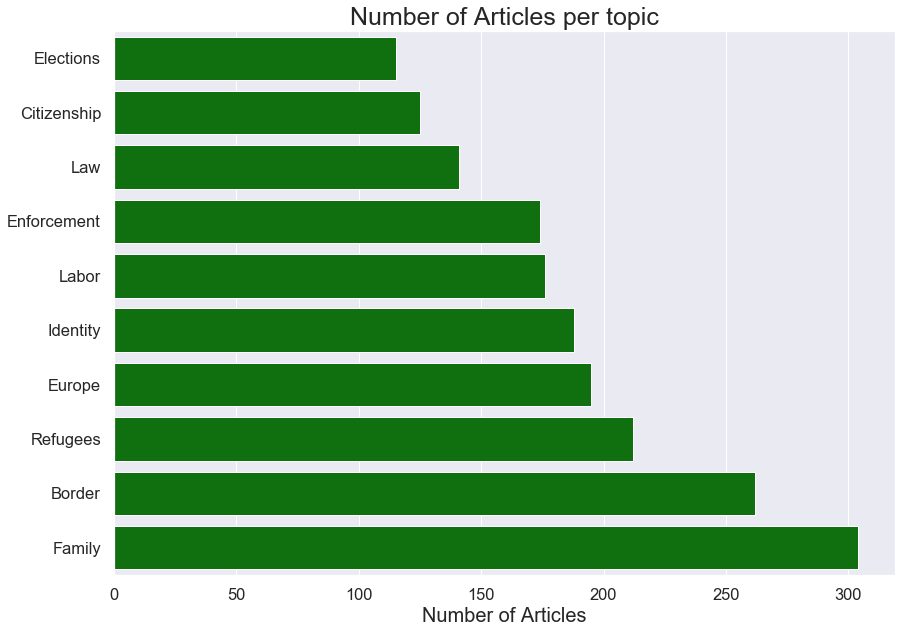

In [34]:
## graph of topic contributions
import seaborn as sns
import matplotlib.pyplot as plt

topic_sum = nmf_df.groupby('topic').size()
topic_sum = topic_sum.to_frame(name='docs')
topic_sum = topic_sum.reset_index()
topic_sum = topic_sum.sort_values('docs')

# plot
#fig, ax = plt.subplots(figsize=(15, 10))
sns.set(font_scale = 1.5)
ax = sns.barplot(x='docs', y='topic', data=topic_sum, color='green')
#ax.set(title = 'Number of Articles per topic', xlabel='Number of Articles', ylabel='')
ax.axes.set_title("Number of Articles per topic",fontsize=25)
ax.set_xlabel("Number of Articles",fontsize=20)
ax.set_ylabel("")
#ax.title('Number of Articles per topic', size=30)
#ax.xlabel('Number of Articles', size=20)
#ax.ylabel('', size=30)
#ax.savefig('/outputs/topic_sum.png')

In [19]:
# merge topics with main text dataframe
topics_index = nmf_df['topic']
text_df = text_df.merge(topics_index, left_index=True, right_index=True)
#text_df.to_csv('outputs/text_df_topics.csv')
text_df.head()

,level_0,all_text,Unnamed: 0,abstract,web_url,snippet,lead_paragraph,source,headline,pub_date,document_type,news_desk,section_name,index,topic
0,0,including behavior next immigration region bil...,0,Adding Nigeria to the expanded list of exclude...,https://www.nytimes.com/2020/02/04/opinion/tru...,Adding Nigeria to the expanded list of exclude...,It’s happening a little bit out of public cons...,The New York Times,The Racism at the Heart of Trump’s ‘Travel Ban’,2020-02-04T10:00:15+0000,article,OpEd,Opinion,0,Identity
1,1,buyer widely including week far maintain priva...,1,Congressional hearings are urgently needed to ...,https://www.nytimes.com/2020/02/07/opinion/dhs...,Congressional hearings are urgently needed to ...,“When the government tracks the location of a ...,The New York Times,The Government Uses ‘Near Perfect Surveillance...,2020-02-08T00:24:47+0000,article,Editorial,Opinion,1,Law
2,2,tattoo widely city daca defendant metro falsif...,2,The bar for being labeled a gang member is low...,https://www.nytimes.com/2020/02/03/opinion/los...,The bar for being labeled a gang member is low...,I found out I was in a gang database — a share...,The New York Times,Are You in a Gang Database?,2020-02-04T00:00:07+0000,article,OpEd,Opinion,2,Crime
3,3,mexico including divide scholar editorial floo...,3,Immigration can invigorate the country. But wh...,https://www.nytimes.com/2020/01/16/opinion/imm...,Immigration can invigorate the country. But wh...,"In 2001, when I was the new Washington corresp...",The New York Times,I’m a Liberal Who Thinks Immigration Must Be R...,2020-01-16T23:48:30+0000,article,OpEd,Opinion,3,Labor
4,4,payback mexico including week feature history ...,4,"For immigrants languishing behind bars, a hung...",https://www.nytimes.com/2020/01/30/opinion/hun...,"For immigrants languishing behind bars, a hung...","On Jan. 29, Immigration and Customs Enforcemen...",The New York Times,Starving for Justice in ICE Detention,2020-01-30T20:30:07+0000,article,OpEd,Opinion,4,Refugees


In [20]:
text_df.shape

(1892, 15)

## Visualization

In [81]:
import seaborn as sns
#p = sns.palplot(sns.color_palette("cubehelix", 20))
#p = sns.color_palette("hls", 20)
#sns.palplot(p)
sns.set(style='white', palette="bright", context='notebook', rc={'figure.figsize':(14,10)})

Valid metrics are ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski', 'nan_euclidean', 'haversine']

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

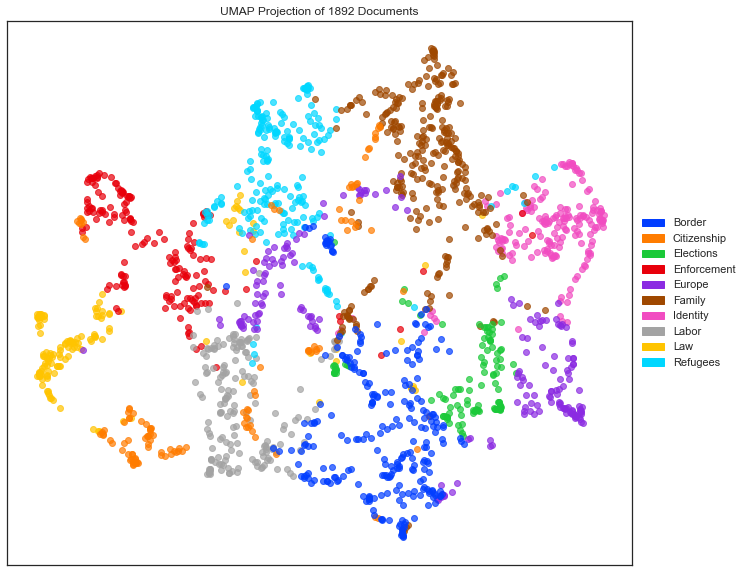

In [85]:
docs = nmf_T
labels = nmf_df['topic']

# Instantiate the text visualizer
umap = UMAPVisualizer(metric='euclidean')
umap.fit(docs, labels)
umap.show(outpath='/Users/AuerPower/Metis/git/steel-man/outputs/topic-cluster2.svg')

## Clustering with K-means

When you do k-means it allows you to include a mix of topics in cluster. just taking the maximum value of a topic matrix could be assigning a topic that is actually really close to another topic. you lose information.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

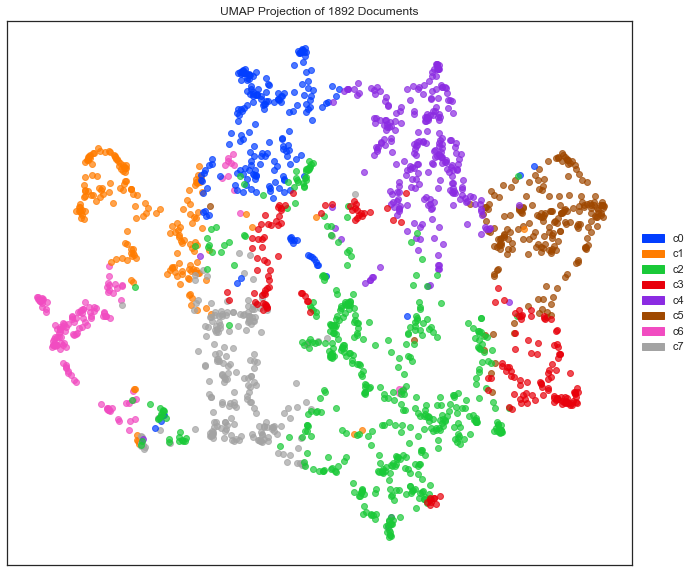

In [134]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import UMAPVisualizer
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

# Load the text data
docs = nmf_T

# Instantiate the clustering model
clusters = KMeans(n_clusters=8, n_jobs = -1, random_state = 42)
clusters.fit(docs)

umap = UMAPVisualizer() 
umap.fit(docs, ["c{}".format(c) for c in clusters.labels_])
umap.show(outpath='/Users/AuerPower/Metis/git/steel-man/outputs/kmeans-cluster2.svg')
#umap.save(, format='svg', transparent=True)

In [136]:
# Create data frame to which topic ended up in which clusters
cluster_df = pd.DataFrame.from_dict({'headline':text_df['headline'],
                                     'snippet':text_df['snippet'],
                                     'topic':text_df['topic'], 
                                     'cluster':clusters.labels_})
cluster_df.head()

,headline,snippet,topic,cluster
0,The Racism at the Heart of Trump’s ‘Travel Ban’,Adding Nigeria to the expanded list of exclude...,Identity,5
1,The Government Uses ‘Near Perfect Surveillance...,Congressional hearings are urgently needed to ...,Law,6
2,Are You in a Gang Database?,The bar for being labeled a gang member is low...,Crime,1
3,I’m a Liberal Who Thinks Immigration Must Be R...,Immigration can invigorate the country. But wh...,Labor,7
4,Starving for Justice in ICE Detention,"For immigrants languishing behind bars, a hung...",Refugees,0


In [167]:
# plot the topics within each cluster
# stacked bar of topics in a cluster
cluster_df.to_csv('/Users/AuerPower/Metis/git/steel-man/outputs/cluster_df.csv')

## Recommender system
I tried threes different types of recommendation systems
1. Cosine similarity and kmeans clustering
2. Cosine similarity and NMF 
3. cosine simlarity between documents

#### K-means cosine recommender system

In [137]:
# Create cluster matrix
cluster_matrix = clusters.transform(docs)

In [138]:
cluster_matrix_df = pd.DataFrame(cluster_matrix)
cluster_matrix_df['cluster'] = clusters.labels_
cluster_matrix_df.head()

,0,1,2,3,4,5,6,7,cluster
0,0.140392,0.147837,0.104325,0.122888,0.117124,0.075079,0.103520,0.115449,5
1,0.125070,0.126488,0.110762,0.127925,0.134345,0.142301,0.049992,0.126502,6
2,0.131575,0.050134,0.131820,0.162578,0.131191,0.156637,0.131900,0.149602,1
3,0.150929,0.118216,0.097341,0.125749,0.132985,0.135650,0.162685,0.085323,7
4,0.056135,0.148681,0.145854,0.162545,0.168236,0.163960,0.142940,0.164924,0


In [139]:
indices = pd.Series(text_df['headline'])

In [140]:
# recommender by cosine similarity within cluster
def recommend_kmeans(headline):
    recommended_steelmen = []
    # get index of the article headline
    idx = indices[indices == headline].index[0]
    # get topic of article
    topic_of_article = cluster_matrix_df.cluster[idx]
    # get all articles of the same topic and drop topic column
    topic_set = cluster_matrix_df[cluster_matrix_df.cluster == topic_of_article].drop('cluster', axis=1)
    # calculate cosine similarity on data frame and select array for article
    cosine_calc = cosine_similarity(topic_set)
    # sort values
    score_series = pd.Series(cosine_calc[0]).sort_values(ascending = True) # this is returning in order of least similar
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        #recommended_steelmen.append(list(cluster_df['headline'], cluster_df['snippet'])[i])
        recommended_steelmen.append([cluster_df['headline'][i], cluster_df['snippet'][i]])
        
    return recommended_steelmen

In [141]:
recommend_kmeans('Slouching Toward Eurabia?')

[['What Now for Europeans Who Love Britain?',
  'An Italian who once lived happily there wonders how Brexit will reshape the feelings of others in the E.U. toward the British.'],
 ['Britain’s Flawed Immigration Strategy',
  'Warnings that Britain will be overrun are exaggerated and counterproductive.'],
 ['Between Folly and Cruelty on Immigration',
  'Can right and left break out of their disastrous cycle?'],
 ['Why Trump Persists',
  'Voters are less tolerant, less empathetic and less interested in integrity than many political analysts thought.'],
 ['The Supreme Court Confronts DACA',
  'Will the justices allow the Trump administration to toss out the Dreamers?'],
 ['Immigration Riddle',
  'The Town of Huntington should commit itself to keep some services going for day laborers, and thus keep homelessness, vagrancy and sickness at bay.'],
 ['An Illegal Immigration Patchwork',
  'The Obama administration should urge the Supreme Court to weigh in against the improper splintering of nat

#### NMF and cosine similarity recommender system

In [97]:
# recommender by cosine similarity within topic
def recommend(headline):
    recommended_steelmen = []
    # get index of the article headline
    idx = indices[indices == headline].index[0]
    # get topic of article
    topic_of_article = nmf_df.topic[idx]
    # get all articles of the same topic and drop topic column
    topic_set = nmf_df[nmf_df.topic == topic_of_article].drop('topic', axis=1)
    # calculate cosine similarity on data frame and select array for article
    cosine_calc = cosine_similarity(topic_set)
    # sort values
    score_series = pd.Series(cosine_calc[0]).sort_values(ascending = True) # this is returning in order of least similar
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        #recommended_steelmen.append(list(text_df['headline'])[i])
        recommended_steelmen.append([text_df['headline'][i], text_df['snippet'][i]])
        
    return recommended_steelmen

#biggest_topic_set = nmf_df[nmf_df.topic_y == biggest_topic]
#cosine_sim = cosine_similarity(nmf_T[biggest_topic_set.index])

In [117]:
recommend('Slouching Toward Eurabia?')

[['Britain’s Flawed Immigration Strategy',
  'Warnings that Britain will be overrun are exaggerated and counterproductive.'],
 ['A Cool Head on Immigration',
  'Gov. Janet Napolitano of Arizona would be a solid choice for homeland security secretary. She has a strong understanding of immigration and its political traps.'],
 ['Immigration and the Elections',
  'David Shipley, the Op-Ed editor, speaks with Lawrence Downes, an editorial writer, about the immigration issues that have played out in this election cycle.'],
 ['Meet Memo, the Marie Kondo of Fitness',
  'In a cluttered world of boutique fitness studios and high-end gear, Guillermo Piñeda Morales reminds us that we don’t need much to be our best.'],
 ['I’m a Liberal Who Thinks Immigration Must Be Restricted',
  'Immigration can invigorate the country. But when it is poorly managed, it can cause social division — just as it’s doing right now.'],
 ['The Immigration Bill Presses On',
  'After two weeks of markup, the fundamental su

#### recommender by cosine similarity only

In [61]:
cosine_sim = cosine_similarity(nmf_T)

In [62]:
# recommender by cosine similarity only
def recommend2(headline, cosine_sim = cosine_sim):
    recommended_steelmen = []
    idx = indices[indices == headline].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = True) # this is returning in order of least similar
    top_10_indices = list(score_series.iloc[0:10].index)
    
    for i in top_10_indices:
        recommended_steelmen.append(list(text_df['headline'])[i])
        
    return recommended_steelmen

In [64]:
recommend2('The Racism at the Heart of Trump’s ‘Travel Ban’')

['The Retro Futurism of Marco Rubio',
 'Pulling Back the Immigration Posses',
 'Jeb Bush Openly Runs for President, Finally',
 'Praise for Bush’s Treasury Choice',
 'Could Ted Cruz Win?',
 'Donald Trump Is Focus of Attacks in the Republican Debate',
 'Could Donald Trump Be Good for Republicans?',
 'Georgia Republicans Know Exactly Who’s at Fault for Gridlock',
 'California’s Trust Act',
 'Confusion Over Secure Communities']